# COMP24112 - Exercise 3: _Face Recognition_

## 1. Task description

You will work on the face recognition and face completion tasks. The provided dataset includes face images of 40 subjects. There are a total of 400 images, with 10 images per subject. Each image contains 32×32=1024 pixels, with 256 grey levels per pixel.

## 2. Preparation

### Setting up

The functions that you need are defined in the source file we have provided you with. To use them you must import it first:

In [5]:
from lab3lib import load_data, show_single_face, show_faces, partition_data, split_left_right, join_left_right, show_split_faces
import numpy as np
import matplotlib.pyplot as plt

Now you can load the data:

In [6]:
data, labels = load_data()

### Visualising the dataset

You can observe the faces stored in a data matrix by using the functions `show_single_face()` and `show_faces()`.

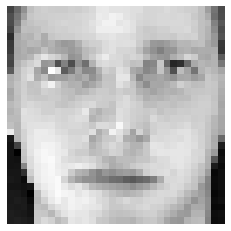

In [7]:
# Display a single example.
show_single_face(data[0, :])

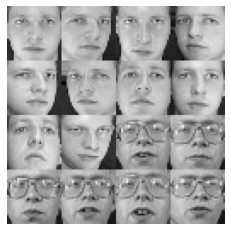

In [8]:
# Display the first 16 examples in a 4x4 grid.
show_faces(data[:16, :], num_per_row=4)

### Splitting into the train and test sets

Normalize your pixel values by 1/255 so that the feature values used in later experiments are between 0 and 1. In general, the normalization trick can make it easier for your to tune parameters in machine learning experiments. A data partition function is supplied to facilitate your experiments. It randomly splits the provided data into the training and test sets, where the training set contains $N$ samples per class and the test set contains
the remaining samples. It takes the labels and the specified number $N$ as the input. It returns the sample indices in the training and test set. For example, the following code divides a given set of 400 samples into a training set containing 3 samples per subject and a test set containing 7 samples per subject:

In [9]:
# normalization
data = data / 255

# partition
tr_ind, te_ind = partition_data(labels, num_per_class=3)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

## 3. $L_2$-regularised least squares solution
### 3.1 Implementation
Now, you will need to implement the function `l2_rls_train` below. It should train a linear model by minimising the $L_2$-regularised sum of squares loss through zeroing the loss gradient. It should support both single-output and multi-output cases. This function should take a set of training samples and a user-specified regularisation parameter $\lambda$ as the input, and return the predicted weights. When $\lambda=0$, use pseudo inverse to implement the solution.

In [10]:
def l2_rls_train(data, labels, lamb=0# Add any other arguments here
          ):
    """
    This function trains a linear model
    By minimising the L2-regularised sum of squares loss

    data: an array of vectors with data you want to train
    labels: input labels for the data
    lamb: regularisation hyper-parameter lambda (default=0)

    Returns:
    w - the trained weights vector
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.c_[np.ones(np.shape(X)[0]), X]
    
    # Compute the coefficient vector.
    X_transpose = np.transpose(X_tilde)
    I = np.identity(np.size(X_transpose, 0))
    #I = np.identity(len(X_tilde[0]))
    if lamb == 0:
        X_pseudo = np.linalg.pinv(X_tilde)
        w = X_pseudo @ y
    else:
        w = np.linalg.inv(X_transpose @ X_tilde + lamb * I) @ X_transpose @ y
    
    # Return model parameters.
    return w

# w = l2_rls_train(tr_data, tr_label, lamb=0)
# print(w)
# w = l2_rls_train(tr_data, tr_label, lamb=1)
# print(w)

Now, implement the function `l2_rls_predict` below. It should take the trained weights and your query data as the input, and return the corresponding prediction.

In [11]:
def l2_rls_predict(w, data):
    """
    Takes trained weights and makes a prediction
    Based on the weights vector

    data: an array of vectors with data you want to predict on
    w: a trained weights vector

    Returns:
    predicted_y - a vector of the predictions made
    """
    
    # This is just to be consistent with the lecture notes.
    X = data
    
    # Compute the prediction.
    X_tilde = np.c_[np.ones(np.shape(X)[0]), X]
    predicted_y = X_tilde @ w

    return predicted_y

# w = l2_rls_train(tr_data, tr_label, lamb=1)
# predicted_y = l2_rls_predict(w, te_data)
# print(predicted_y)

### 3.2 Experiments

Start to use your implemented functions to perform the following experiments.

#### Experiment 1: Binary Classification

Start with a binary classification task to classify face images for subjects “1” and “30”.

Train three classifiers:
1. Set $y=-1$ for samples from “1” and $y=+1$ for samples from “30” for training a linear model, and use the threshold $T= 0$ to obtain the class prediction.
2. Set $y=0$ for samples from “1” and $y=1$ for samples from “30” for training a linear model, and use the threshold $T= 0.5$ to obtain the class prediction.
2. Set $y=1$ for samples from “1” and $y=30$ for samples from “30” for training a linear model, and use the threshold $T= 15.5$ to obtain the class prediction.

Randomly select 3 images per subject for training, and use the remaining images for testing. Train your classifier 1 and test it with a fixed regularisation parameter $\lambda$=0. Repeat this process 50 times and record the training and test errors.

In [12]:
# Your code goes here


def binary_predict_threshold(predicted_y, y_1, y_30, threshold):
    predicted_y_classified = []
    for i in predicted_y:
        if i >= threshold:
            predicted_y_classified = np.append(predicted_y_classified, y_30)
        elif i < threshold:
            predicted_y_classified = np.append(predicted_y_classified, y_1)
    return predicted_y_classified

# Get the new data and labels for our binary experiment for samples 1 and 30
new_labels = labels[labels==1]
new_labels = np.append(new_labels, labels[labels==30])
new_data = data[0:10, :]
new_data = np.append(new_data, data[290:300, :], axis=0)

testing_number = 50

from sklearn.metrics import accuracy_score
threshold = 0
y_1 = -1
y_30 = 1
accuracy_1 = []
errors_1 = []

for index in range(0, testing_number):
    
    # Take data only from those 2 samples
    tr_ind, te_ind = partition_data(new_labels, num_per_class=3)
    tr_data = new_data[tr_ind, :]
    te_data = new_data[te_ind, :]
    
    tr_label = new_labels[tr_ind]
    tr_label = np.where(tr_label==1, y_1, tr_label)
    tr_label = np.where(tr_label==30, y_30, tr_label)
    
    te_label = new_labels[te_ind]
    te_label = np.where(te_label==1, y_1, te_label)
    te_label = np.where(te_label==30, y_30, te_label)
    
    w = l2_rls_train(tr_data, tr_label)
    predicted_y = l2_rls_predict(w, te_data)

    predicted_y_classified = binary_predict_threshold(predicted_y, y_1, y_30, threshold)
            
    accuracy_1.append(accuracy_score(te_label, predicted_y_classified))
    errors_1.append(np.sum(predicted_y_classified != te_label))

Repeat the same experiment for classifier 2.

In [13]:
# Your code goes here
threshold = 0.5
y_1 = 0
y_30 = 1
accuracy_2 = []
errors_2 = []

for index in range(0, testing_number):
    
    tr_ind, te_ind = partition_data(new_labels, num_per_class=3)
    tr_data = new_data[tr_ind, :]
    te_data = new_data[te_ind, :]
    
    tr_label = new_labels[tr_ind]
    tr_label = np.where(tr_label==1, y_1, tr_label)
    tr_label = np.where(tr_label==30, y_30, tr_label)
    
    te_label = new_labels[te_ind]
    te_label = np.where(te_label==1, y_1, te_label)
    te_label = np.where(te_label==30, y_30, te_label)
    
    w = l2_rls_train(tr_data, tr_label)
    predicted_y = l2_rls_predict(w, te_data)

    predicted_y_classified = binary_predict_threshold(predicted_y, y_1, y_30, threshold)
            
    accuracy_2.append(accuracy_score(te_label, predicted_y_classified))
    errors_2.append(np.sum(predicted_y_classified != te_label))


Repeat the same experiment for classifier 3.

In [14]:
# Your code goes here
threshold = 15.5
y_1 = 1
y_30 = 30
accuracy_3 = []
errors_3 = []

for index in range(0, testing_number):
    
    tr_ind, te_ind = partition_data(new_labels, num_per_class=3)
    tr_data = new_data[tr_ind, :]
    te_data = new_data[te_ind, :]
    
    tr_label = new_labels[tr_ind]
    tr_label = np.where(tr_label==1, y_1, tr_label)
    tr_label = np.where(tr_label==30, y_30, tr_label)
    
    te_label = new_labels[te_ind]
    te_label = np.where(te_label==1, y_1, te_label)
    te_label = np.where(te_label==30, y_30, te_label)
    
    w = l2_rls_train(tr_data, tr_label)
    predicted_y = l2_rls_predict(w, te_data)

    predicted_y_classified = binary_predict_threshold(predicted_y, y_1, y_30, threshold)
            
    accuracy_3.append(accuracy_score(te_label, predicted_y_classified))
    errors_3.append(np.sum(predicted_y_classified != te_label))
    

Print out the mean and the std values of the test errors of the three classifiers.

In [15]:
# Your code goes here
print("Classifier 1 Mean:", np.mean(accuracy_1))
print("Classifier 2 Mean:", np.mean(accuracy_2))
print("Classifier 3 Mean:", np.mean(accuracy_3))
print("Classifier 1 std values:", np.std(accuracy_1))
print("Classifier 2 std values:", np.std(accuracy_2))
print("Classifier 3 std values:", np.std(accuracy_3))
print("Classifier 1 Error count: %i\n%s" % (np.sum(errors_1) ,errors_1))
print("Classifier 2 Error count: %i\n%s" % (np.sum(errors_2) ,errors_2))
print("Classifier 3 Error count: %i\n%s" % (np.sum(errors_3) ,errors_3))
print("Classifier 1 Error rate: %f" % (np.sum(errors_1) / (len(predicted_y)*testing_number)))
print("Classifier 2 Error rate: %f" % (np.sum(errors_2) / (len(predicted_y)*testing_number)))
print("Classifier 3 Error rate: %f" % (np.sum(errors_3) / (len(predicted_y)*testing_number)))

Classifier 1 Mean: 0.92
Classifier 2 Mean: 0.9442857142857143
Classifier 3 Mean: 0.9242857142857143
Classifier 1 std values: 0.09107072828862416
Classifier 2 std values: 0.07462833078062274
Classifier 3 std values: 0.10537590631948587
Classifier 1 Error count: 56
[0, 0, 1, 0, 3, 2, 1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 2, 3, 2, 0, 1, 0, 2, 1, 1, 4, 0, 3, 0, 1, 3, 0, 3, 3, 0, 0, 0, 1, 0, 0, 3, 3, 0]
Classifier 2 Error count: 39
[2, 3, 3, 2, 1, 0, 0, 0, 2, 3, 1, 1, 3, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0, 2, 0, 2]
Classifier 3 Error count: 53
[0, 0, 3, 0, 0, 1, 1, 1, 4, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 1, 3, 0, 2, 0, 0, 0, 0, 2, 1, 2, 7, 0, 0, 0, 3, 2, 0, 0, 2, 1, 0, 3, 0, 0, 3, 0, 0, 1, 1, 0]
Classifier 1 Error rate: 0.080000
Classifier 2 Error rate: 0.055714
Classifier 3 Error rate: 0.075714


#### Experiment 2: Multi-class Classification

Now, proceed to the multi-class classification task to classify face images for all the 40 subjects.

Split your data to two sets: the training set contains 5 randomly selected images per subject and the test set contains the remaining images. The training set is used to train the model and select hyper-parameter $\lambda$, while the test set is only for final assessment of the trained classifier with the selected $\lambda$. 

Design an appropriate and complete machine learning experiment, which should include the training, hyper-parameter selection and evaluation stages. You can choose from the random subsampling, $k$-fold CV and LOO approaches for hyper-parameter selection. In the evaluation, you should construct a $40\times 40$ classification error matrix (confusion matrix) for test samples. 

Write your code below and make sure it compiles. 

In [53]:
# Your code goes here
# Note that you may find it helpful to use one-hot encoding to deal with multi-class labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from random import sample
from sklearn.metrics import confusion_matrix

def onehot_encoding_multi(labels_encoded):
    # One-hot encoding function for a labels vector
    labels_encoder = LabelEncoder()
    integer = labels_encoder.fit_transform(labels_encoded)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer = integer.reshape(len(integer), 1)
    onehot_labels = onehot_encoder.fit_transform(integer)
    return onehot_labels, onehot_encoder

# # Change lambdas to test here
lambdas = [0] + [1*(10**x) for x in range(-6,0)] + [x for x in np.arange(0.25, 3.25, 0.25)] + [4, 5] + [1*(10**x) for x in range(1,5)]
#print("Lambdas:", lambdas)

# Number of times to test for each lambda
testing_number = 5

accuracy = np.zeros(shape=(len(lambdas),testing_number))
errors = np.zeros(shape=(len(lambdas),testing_number))

# Split whole data in 2 parts, one for finding the best lambda and one for training and testing it
tr_ind, te_ind = partition_data(labels, num_per_class=4)
tr_data = data[tr_ind, :]
tr_label = labels[tr_ind]
te_data = data[te_ind, :]
te_label = labels[te_ind]

# Now train and test for the best lambda
index = 0
for l in lambdas:
    for i in range(0, testing_number):
        
        # Use a part of half of the original data for training, then the other part for testing
        ind_1, ind_2 = partition_data(tr_label, num_per_class=3)
        l_tr_data = tr_data[ind_1, :]
        l_tr_label = tr_label[ind_1]
        l_te_data = tr_data[ind_2, :]
        l_te_label = tr_label[ind_2]

        correct_y = np.reshape(l_te_label, (-1, 1))
        correct_y = correct_y - 1

        # One hot encoding for multi labels
        onehot_labels, onehot_encoder = onehot_encoding_multi(l_tr_label)
        
        W = l2_rls_train(l_tr_data, onehot_labels, lamb=l)

        predicted_y = l2_rls_predict(W, l_te_data)

        predicted_y_result = onehot_encoder.inverse_transform(predicted_y)

        accuracy[index][i]=accuracy_score(correct_y, predicted_y_result)
        errors[index][i]=np.sum(predicted_y_result != correct_y)
    index+=1

best_accuracy = 0
accuracy_index = 0
least_errors = len(predicted_y)
least_errors_index = 0
lowest_errors = 1
lowest_errors_index = 0

# Check for the best lambda and print all results
for i in range(len(lambdas)):
#     print("Lambda: %f | Accuracy: %f Errors: %f | Error Rates: %f" % (lambdas[i], np.mean(accuracy[i]), np.sum(errors[i]), np.sum(errors[i]) / (len(predicted_y)*testing_number)))
    if best_accuracy <= np.mean(accuracy[i]):
        best_accuracy = np.mean(accuracy[i])
        accuracy_index = i
    if least_errors >= np.sum(errors[i]):
        least_errors = np.sum(errors[i])
        least_errors_index = i
    if lowest_errors >=  np.sum(errors[i])/(len(predicted_y)*testing_number):
        lowest_errors = np.sum(errors[i])/(len(predicted_y)*testing_number)
        lowest_errors_index = i

# print()
# print("Best accuracy is: %f for Lambda - %f" % (best_accuracy, lambdas[accuracy_index]))
# print("Least errors are: %f for Lambda - %f" % (least_errors, lambdas[least_errors_index]))
# print("Lowest error rate: %f for Lambda - %f" % (lowest_errors, lambdas[lowest_errors_index]))
# print()
print("The lambda with the best evaluation is: %f" % (lambdas[accuracy_index]))
# CONFUSION MATRIX
best_lambda = lambdas[accuracy_index]

# Now take the last half of the initial data and train and test the best lambda on it
ind_1, ind_2 = partition_data(te_label, num_per_class=3)
tr_data_final = te_data[ind_1, :]
tr_label_final = te_label[ind_1]
te_data_final = te_data[ind_2, :]
te_label_final = te_label[ind_2]

correct_y = np.reshape(te_label_final, (-1, 1))
correct_y = correct_y - 1

# One hot encoding
onehot_labels, onehot_encoder = onehot_encoding_multi(tr_label_final)

W = l2_rls_train(tr_data_final, onehot_labels, lamb=best_lambda)
predicted_y = l2_rls_predict(W, te_data_final)
predicted_y_result = onehot_encoder.inverse_transform(predicted_y)
labels_confusion_matrix = [x for x in range(1, 41)]

y_true = correct_y.flatten()
y_pred = predicted_y_result.flatten()
acc_score = accuracy_score(y_true, y_pred)

def confusion_matrix_calculation(y_true, y_pred):
    # Get the number of classes
    no_classes = len(np.unique(true))
    
    # Initialise the confusion matrix with 0's and size based on the no of classes
    confusion_matrix = np.zeros((no_classes, no_classes))
    
    # Compute the confusion matrix with the TP, FP, FN, TN
    for i in range(0, len(y_true)):
        # One label by one
        confusion_matrix[y_true[i]][y_pred[i]] += 1
        
    # Transform matrix type in int for readability
    confusion_matrix = confusion_matrix.astype(int)
    
    return confusion_matrix

# To see the whole confusion matrix
np.set_printoptions(edgeitems=20, linewidth=1000)

# Print labels, accuracy and confusion matrix for it
print(y_true + 1)
print(y_pred + 1)
print()
print("With an accuracy of %f" % (acc_score))
print("The confusion matrix for this lambda is")

#print("Confusion Matrix WITH sklearn\n", confusion_matrix(y_true + 1, y_pred + 1, labels=labels_confusion_matrix))

print("Confusion Matrix WITHOUT sklearn\n", confusion_matrix_calculation(y_true, y_pred))

The lambda with the best evaluation is: 1.000000
[ 1  1  1  2  2  2  3  3  3  4  4  4  5  5  5  6  6  6  7  7  7  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 13 13 14 14 14 15 15 15 16 16 16 17 17 17 18 18 18 19 19 19 20 20 20 21 21 21 22 22 22 23 23 23 24 24 24 25 25 25 26 26 26 27 27 27 28 28 28 29 29 29 30 30 30 31 31 31 32 32 32 33 33 33 34 34 34 35 35 35 36 36 36 37 37 37 38 38 38 39 39 39 40 40 40]
[16  1  5  2  1  2  3 35  3  4  4  4  5 40  5  6  6  6  7  7 18  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 13 25 39 14 14 14 15 15 15 16 16 16  4  7 17 18 12 18 19 19 19 20 18 20 18 21 21 22 22 22 23 23 23  8 24 24 38 25 25 26 26 26 27 27 27 28 28 28 29 33 29 30 30 30 31 31 31 32 32 26 33 33 33 34 34 34 35 35 35 36 36 36 37 37 37 38 38 38 39 25 39 40 40 40]

With an accuracy of 0.850000
The confusion matrix for this lambda is
Confusion Matrix WITHOUT sklearn
 [[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 Pick some subjects that are considered the easist to recognise by your classifier, and print the test images from these subjects below.

[40.0, 11.0, 19.0]


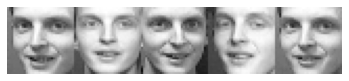

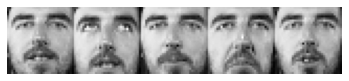

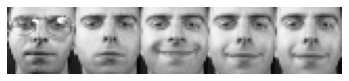

In [17]:
true = np.split(y_true, 40)
predicted = np.split(y_pred, 40)
true = np.array(true)
predicted = np.array(predicted)
difficulty_list = np.zeros(shape=(len(true), 2))

for i in range(len(true)):
    difficulty_list[i][0]=i+1
    difficulty_list[i][1]=np.sum(true[i]==predicted[i])

# The classes with the highest error rates, at the beginning
# And the classes with the lowest error rates or none, at the end
difficulty_list = difficulty_list[difficulty_list[:,1].argsort()]

#print(difficulty_list)

easier_samples = []
easier_samples.append(difficulty_list[len(difficulty_list)-1][0])
easier_samples.append(difficulty_list[len(difficulty_list)-2][0])
easier_samples.append(difficulty_list[len(difficulty_list)-3][0])
print(easier_samples)

show_faces(te_data[:int(easier_samples[0])*5][int(easier_samples[0])*5-5:], num_per_row=5)
show_faces(te_data[:int(easier_samples[1])*5][int(easier_samples[1])*5-5:], num_per_row=5)
show_faces(te_data[:int(easier_samples[2])*5][int(easier_samples[2])*5-5:], num_per_row=5)

 Pick some subjects that are considered the most difficult to recognise by your classifier, and print the misclassified test images from these subjects below.

[1.0, 36.0, 5.0]


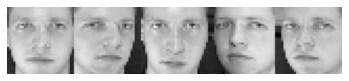

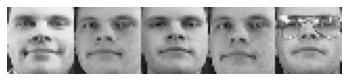

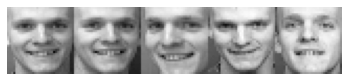

In [18]:
harder_samples = []
harder_samples.append(difficulty_list[0][0])
harder_samples.append(difficulty_list[1][0])
harder_samples.append(difficulty_list[2][0])
print(harder_samples)

show_faces(te_data[:int(harder_samples[0])*5][int(harder_samples[0])*5-5:], num_per_row=5)
show_faces(te_data[:int(harder_samples[1])*5][int(harder_samples[1])*5-5:], num_per_row=5)
show_faces(te_data[:int(harder_samples[2])*5][int(harder_samples[2])*5-5:], num_per_row=5)

#### Experiment 3: Face Completion

The task is to predic the 512 pixels of the right face from the 512 pixels of the left face by formulating a regression task.

The following command can be used to extract the left and right faces from the input data.

In [19]:
left, right = split_left_right(data)

And you can visualise them with the function `show_split_faces()`:

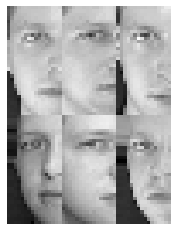

In [20]:
show_split_faces(left[:6, :], num_per_row=3)

Build a face completion model using your functions implemented earlier. Design an experiment to assess your model, which should include appropriate training and testing. Use mean absolute percentage error to evaluate the regression performance. You do not need to bother with hyper-parameter selection, but simply set $\lambda$=0.

Write your code below and make sure it compiles.

In [21]:
# Your code goes here
# Take only left data and right labels
tr_ind, te_ind = partition_data(labels, num_per_class=5)

tr_data = left[tr_ind, :]
tr_label = right[tr_ind, :]
te_data = left[te_ind, :]
te_label = right[te_ind, :]

W = l2_rls_train(tr_data, tr_label, lamb=0)
predicted_y = l2_rls_predict(W, te_data)

MAPE = np.mean(np.abs((te_label - predicted_y) / te_label)) * 100

print("The mean absolute percentage error is:", MAPE)

The mean absolute percentage error is: 22.109665749940863


Visualise and compare the ground truth face (include both the left and right parts) and the completed face (include both the true left and predicted right parts) for 3 randomly chosen testing samples below. You can use `join_left_right(left, right)` to concatenate the left and right halves of a set of faces.

Correct + Predicted faces of samples [12, 34, 16]


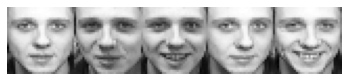

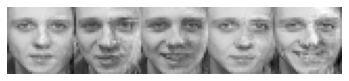

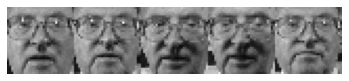

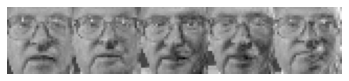

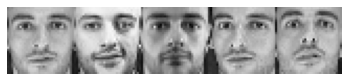

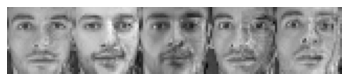

In [22]:
# Your code goes here
import random

samples = random.sample(range(1, 41), 3)

# Now join random faces and see them completed on the right, from the left
test_faces = join_left_right(te_data, te_label)
predicted_faces = join_left_right(te_data, predicted_y)

print("Correct + Predicted faces of samples", samples)

for i in samples:
    show_faces(test_faces[:i*5][i*5-5:], num_per_row=5)
    show_faces(predicted_faces[:i*5][i*5-5:], num_per_row=5)



## 4. Gradient descent for training linear least squares model

Now, implement the function `lls_gd_train` below. It should train a single-output linear model by minimising the sum of squares loss using the gradient descent approach. It should take the iteration number $N$ and the learning rate $\eta$ as the input. To keep things simple, you can fix the initial guess of the model weights $\mathbf{w}$ as zeros. It should record and return the weights and costs of linear least squares model calculated in all the iterations.

In [23]:
def lls_gd_train(data, labels, learning_rate, N # Add any other arguments here if needed
          ):
    """
     This function trains a single-output linear model
     by minimising the sum of squares loss
     using the gradient descent approach
     Calculating the weights and the costs

    data: an array of vectors with data you want to train
    labels: input labels for the data
    learning_rate: rate at which to make changes to the weight
    N: at which iterations to use gradient descent

    Returns:
    cost_all - costs of the linear least squares calculated
    w_all - weights of the linear least squares calculated
    """
    
    # This is just to be consistent with the lecture notes.
    X, y = data, labels
    
    # Expand X with a column of ones.
    X_tilde = np.c_[np.ones(np.shape(X)[0]), X]
    
    # Weight initialization
    w = np.zeros(X_tilde.shape[1])
    
    # GD update of weights
    cost_all, w_all = [], []
    for i in range(N):
        
        # cost and gradient descent of the linear least squares model
        gd = X_tilde.T @ X_tilde @ w - X_tilde.T @ y
        cost = (np.sum((X_tilde @ w - y) ** 2)) / 2
        
        # Weight update
        w = w - gd * learning_rate
        
        # save w and cost of each iteration in w_all and cost_all 
        w_all.append(w)
        cost_all.append(cost)
    
    # Return model parameters.
    return cost_all, w_all

Apply this function to classify images from subject 1 and subject 30. You only need to conduct the experiment for one training-test trial, where 3 images from each subject are used for training and the remaining 7 images for testing.

Set your learning rate small, e.g., $\eta=10^{-3}$, and use a reasonable iteration number, e.g., $N=200$, to train your model. Plot in three figures (1) the change of your sum-of-squares error loss that you minimise, (2) the change of the classification accuracy for training samples, and (3) the change of the classification accuracy for test samples over iterations. Write your code below and make sure it compiles. 

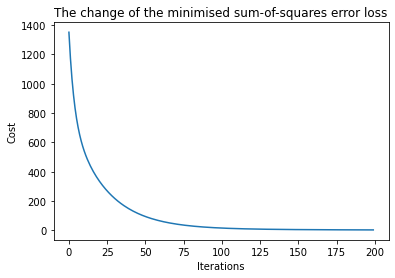

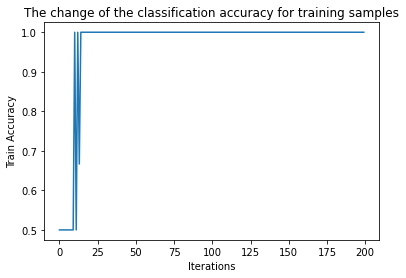

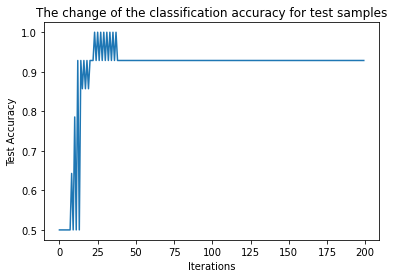

In [24]:
# Your code goes here
threshold = 15.5
y_30 = 30
y_1 = 1
l_rate = 1e-03
iterations = 200

# Select the new data and labels
new_labels = labels[labels==1]
new_labels = np.append(new_labels, labels[labels==30])
new_data = data[0:10, :]
new_data = np.append(new_data, data[290:300, :], axis=0)

tr_ind, te_ind = partition_data(new_labels, num_per_class=3)

tr_data = new_data[tr_ind, :]
te_data = new_data[te_ind, :]

tr_label = new_labels[tr_ind]
tr_label = np.where(tr_label==1, y_1, tr_label)
tr_label = np.where(tr_label==30, y_30, tr_label)
    
te_label = new_labels[te_ind]
te_label = np.where(te_label==1, y_1, te_label)
te_label = np.where(te_label==30, y_30, te_label)

cost_all, w_all = lls_gd_train(tr_data, tr_label, l_rate, iterations)

accuracy_train = []
accuracy_test = []

# Train and test all the weights from the loss function
for w in w_all:
    #Train
    predicted_y_train = l2_rls_predict(w, tr_data)
    
    predicted_y_classified = binary_predict_threshold(predicted_y_train, y_1, y_30, threshold)
    
    accuracy_train.append(accuracy_score(tr_label, predicted_y_classified))

    # Test
    predicted_y_test = l2_rls_predict(w, te_data)
    
    predicted_y_classified = binary_predict_threshold(predicted_y_test, y_1, y_30, threshold)
    
    accuracy_test.append(accuracy_score(te_label, predicted_y_classified))

# Plot the resulting cost, and both train and test accuracies
cost_all = np.array(cost_all)
accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

plt.title('The change of the minimised sum-of-squares error loss')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.plot(cost_all)
plt.show()

plt.title('The change of the classification accuracy for training samples')
plt.xlabel('Iterations')
plt.ylabel('Train Accuracy')
plt.plot(accuracy_train)
plt.show()

plt.title('The change of the classification accuracy for test samples')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.plot(accuracy_test)
plt.show()

Try a larger learning rate, e.g., $\eta=10^{-2}$, and produce the same three plots by training the model for $N=200$ iterations. Write your code below and make sure it compiles. 

<ipython-input-23-1b65326a2853>:34: RuntimeWarning: overflow encountered in square
  cost = (np.sum((X_tilde @ w - y) ** 2)) / 2


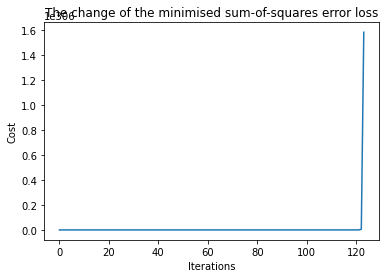

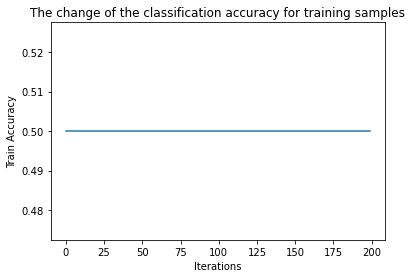

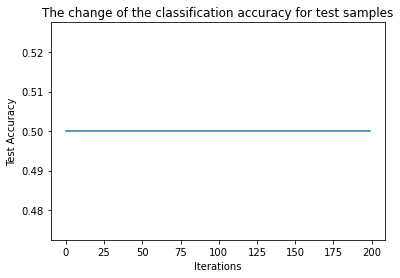

In [25]:
# Your code goes here
threshold = 15.5
y_30 = 30
y_1 = 1
l_rate = 1e-02
iterations = 200

# Select the new data and labels
new_labels = labels[labels==1]
new_labels = np.append(new_labels, labels[labels==30])
new_data = data[0:10, :]
new_data = np.append(new_data, data[290:300, :], axis=0)

tr_ind, te_ind = partition_data(new_labels, num_per_class=3)

tr_data = new_data[tr_ind, :]
te_data = new_data[te_ind, :]

tr_label = new_labels[tr_ind]
tr_label = np.where(tr_label==1, y_1, tr_label)
tr_label = np.where(tr_label==30, y_30, tr_label)
    
te_label = new_labels[te_ind]
te_label = np.where(te_label==1, y_1, te_label)
te_label = np.where(te_label==30, y_30, te_label)

cost_all, w_all = lls_gd_train(tr_data, tr_label, l_rate, iterations)

accuracy_train = []
accuracy_test = []

# Train and test all the weights from the loss function
for w in w_all:
    #Train
    predicted_y_train = l2_rls_predict(w, tr_data)
    
    predicted_y_classified = binary_predict_threshold(predicted_y_train, y_1, y_30, threshold)
    
    accuracy_train.append(accuracy_score(tr_label, predicted_y_classified))

    # Test
    predicted_y_test = l2_rls_predict(w, te_data)
    
    predicted_y_classified = binary_predict_threshold(predicted_y_test, y_1, y_30, threshold)
    
    accuracy_test.append(accuracy_score(te_label, predicted_y_classified))

# Plot the resulting cost, and both train and test accuracies
cost_all = np.array(cost_all)
accuracy_train = np.array(accuracy_train)
accuracy_test = np.array(accuracy_test)

plt.title('The change of the minimised sum-of-squares error loss')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.plot(cost_all)
plt.show()

plt.title('The change of the classification accuracy for training samples')
plt.xlabel('Iterations')
plt.ylabel('Train Accuracy')
plt.plot(accuracy_train)
plt.show()

plt.title('The change of the classification accuracy for test samples')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.plot(accuracy_test)
plt.show()

#### Remember that all graphs should have axis labels and a title.

## 5. Reflection and analysis
Finally, observe and reflect on all the results you have obtained in each experiment, and try to interpret them using your machine learning knowledge. Be ready to answer the questions asked by GTA in your face-to-face marking, regarding to your implementation, results, as well as analysis and interpretation of your results.